- Normal
    - Tension_Normal.csv
    - NTRNL_Normal # subfolder
        - 05-31 23_35_19.txt
        ...
    - XTRNL_Normal # subfolder
        - 20230531_233519.csv
        ...
- CoreExposed
    - Tension_CoreExposed.csv
    - NTRNL_CoreExposed # subfolder
        - 06-01 16_04_36.txt
        ...
    - XTRNL_CoreExposed # subfolder
        - 20230601_160436.csv
        ...
- CoreSevered
    - Tension_CoreSevered.csv
    - NTRNL_CoreSevered # subfolder
        - 06-01 01_49_17.txt
        ...
    - XTRNL_CoreSevered # subfolder
        - 20230601_014917.csv
        ...  
- SideDamaged
    - Tension_SideDamaged.csv
    - NTRNL_SideDamaged # subfolder
        - 05-31 20_54_14.txt
        ...
    - XTRNL_SideDamaged # subfolder
        - 20230531_205414.csv
        ...

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import scipy.stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from scipy.spatial import distance
import warnings

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

##### 수집한 신호로부터 대푯값 추출 및 표준화
##### 변수 'Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Type', 'ConfucionMatrix' 생성

In [2]:
Directory_Path = 'C:/Users/99kit/Desktop/CapstoneDesign2/'
list_root_directory = ['Normal', 'CoreExposed', 'CoreSevered', 'SideDamaged']

def calculate_statistics(data):
    mean = np.mean(data)
    var = np.var(data)
    skew = scipy.stats.skew(data)
    kurt = scipy.stats.kurtosis(data)
    return mean, var, skew, kurt

data_frames = {}

for directory in list_root_directory:
    os.chdir(os.path.join(Directory_Path, directory))

    Tension = pd.read_csv(f"Tension_{directory}.csv", encoding='cp949')
    Tension['Unnamed: 0'] = pd.to_datetime(Tension['Unnamed: 0'], format='[%Y/%m/%d] %H:%M:%S')
    Tension['Formatted_Time'] = Tension['Unnamed: 0'].dt.strftime(f'NTRNL_{directory}\\%m-%d %H_%M_%S.txt')

    list_max_values = []
    for csv_file in glob.glob('*/*.csv'):
        df = pd.read_csv(csv_file)
        list_max_values.append(df['External Sound'].max())
    Tension['Max_EXT_Sound'] = list_max_values

    statistics = {}
    for txt_file in glob.glob('*/*.txt'):
        with open(txt_file, 'r') as file:
            data = [int(line.strip().split(',')[0]) for line in file if len(line.strip().split(',')) == 3]
            statistics[txt_file] = calculate_statistics(data)

    for stat_name in ['Mean', 'Variance', 'Skewness', 'Kurtosis']:
        Tension[stat_name] = Tension['Formatted_Time'].map(lambda x: statistics.get(x, (np.nan, np.nan, np.nan, np.nan))[['Mean', 'Variance', 'Skewness', 'Kurtosis'].index(stat_name)])
        Tension[stat_name].interpolate(inplace=True)

    Q1 = Tension['Max_EXT_Sound'].quantile(0.25)
    Q3 = Tension['Max_EXT_Sound'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_max_ext_sound = Tension[(Tension['Max_EXT_Sound'] < lower_bound) | (Tension['Max_EXT_Sound'] > upper_bound)]

    Q1_mean = Tension['Mean'].quantile(0.25)
    Q3_mean = Tension['Mean'].quantile(0.75)
    IQR_mean = Q3_mean - Q1_mean
    lower_bound_mean = Q1_mean - 1.5 * IQR_mean
    upper_bound_mean = Q3_mean + 1.5 * IQR_mean
    outliers_mean_ntrnl_sound = Tension[(Tension['Mean'] < lower_bound_mean) | (Tension['Mean'] > upper_bound_mean)]

    common_indices = outliers_max_ext_sound.index.intersection(outliers_mean_ntrnl_sound.index)
    Tension.loc[common_indices, 'Mean'] = np.nan
    Tension['Mean'].interpolate(inplace=True)

    Tension = Tension.drop(['Formatted_Time', 'Max_EXT_Sound'], axis=1)
    Tension['Type'] = directory

    Tension.loc[Tension['Type'] != 'Normal', 'Confusion Matrix'] = 'Others' # 이전에 Anomaly로 표현함
    Tension.loc[Tension['Type'] == 'Normal', 'Confusion Matrix'] = 'Normal'

    data_frames[directory] = Tension

# tb_data = pd.concat(data_frames.values(), ignore_index=True)
# tb_data = tb_data.rename(columns={'벨트처짐': 'Tension'})

# list_independent_variables = ['Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis']

# data_standardized = StandardScaler().fit_transform(tb_data[list_independent_variables])
# tb_data[list_independent_variables] = pd.DataFrame(data_standardized, columns=list_independent_variables)

# tb_data

In [3]:
# 위의 코드 전체 재실행이 너무 오래 걸려서 따로 똑 떼어냄

tb_data = pd.concat(data_frames.values(), ignore_index=True)
tb_data = tb_data.rename(columns={'벨트처짐': 'Tension'})

list_independent_variables = ['Tension', 'Mean', 'Variance', 'Skewness', 'Kurtosis']

data_standardized = StandardScaler().fit_transform(tb_data[list_independent_variables])
tb_data[list_independent_variables] = pd.DataFrame(data_standardized, columns=list_independent_variables)

tb_data

,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix
0,2023-05-31 23:35:19,-0.216452,-1.780290,0.235485,-0.209677,0.005047,Normal,Normal
1,2023-05-31 23:35:20,-0.204667,-0.470556,0.059753,0.655876,-0.858885,Normal,Normal
2,2023-05-31 23:35:21,-0.216452,-1.040747,0.163329,0.333842,-0.392346,Normal,Normal
3,2023-05-31 23:35:22,-0.240023,-1.600883,0.503912,-0.609384,-0.731790,Normal,Normal
4,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,Normal
...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,Others
14251,2023-05-31 21:53:56,-0.240023,-0.831468,-0.717530,0.131856,0.607366,SideDamaged,Others
14252,2023-05-31 21:53:57,0.007473,-0.539040,0.135900,0.228446,-0.148179,SideDamaged,Others
14253,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,Others


##### Mahalanobis 거리를 이용한 관리한계 설정을 위해 Normal 데이터의 다변량(근데 왜 Multiple이 아니라 Multivariate임?) 정규성 검정...은 나중에 제대로 해봐야겠다.
##### Normal 데이터가 각 차원에서 여러 군집으로 나뉘지 않는 다는 것만 확인하면 될 것 같다.
##### 4가지 Type의 분포 확인

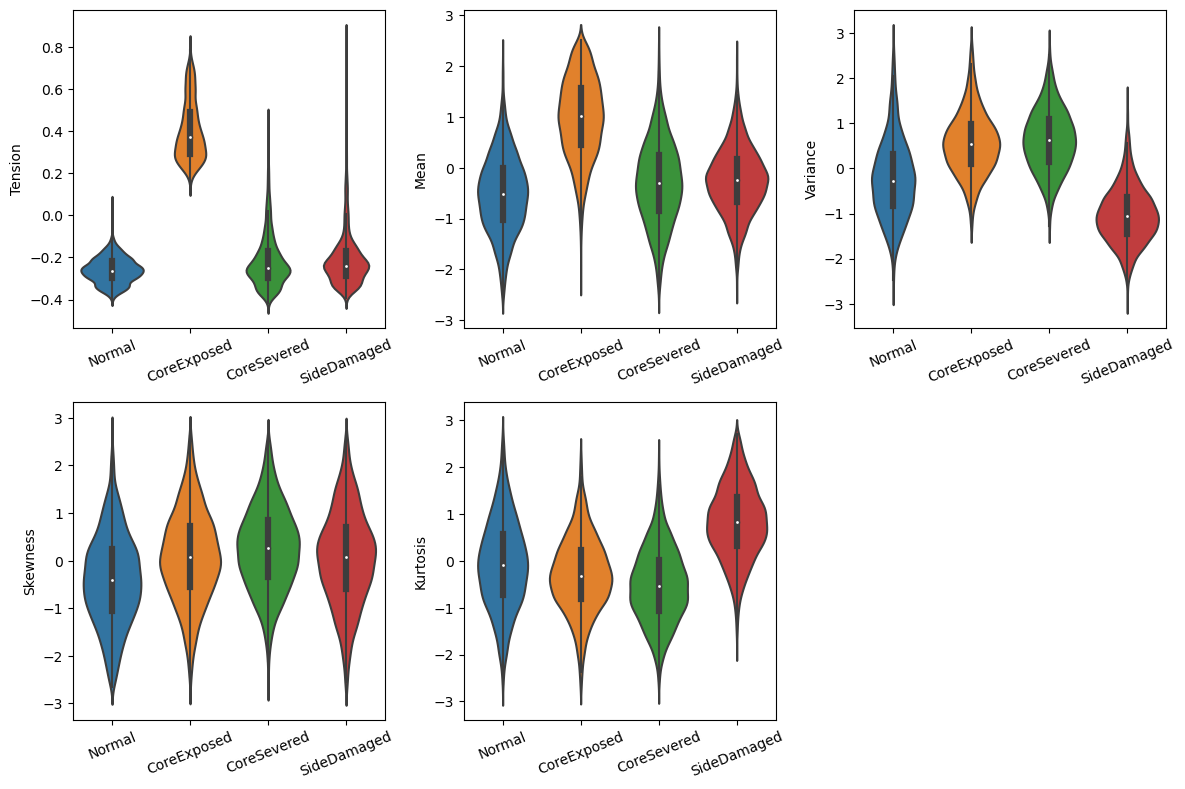

In [4]:
# 극단 이상치 제거한 바이올린 플롯 그리기
plt.figure(figsize=(12, 8))  # 그림 크기 설정

# 각 열에 대해 이상치 제거한 박스 플롯 그리기
for i, col in enumerate(list_independent_variables, 1):
    plt.subplot(2, 3, i)  # 2x3 그리드에서 i번째 위치에 서브플롯 생성

    # 이상치 제거 (IQR 기반)
    Q1 = tb_data[col].quantile(0.25)
    Q3 = tb_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_no_outliers = tb_data[(tb_data[col] >= lower_bound) & (tb_data[col] <= upper_bound)]

    sns.violinplot(x= 'Type', y = col, data=data_no_outliers)
    # plt.title(f'{col} (Outliers Removed) by Type')  # 서브플롯 제목 설정
    plt.xlabel('')#Type')  # x축 레이블 설정
    plt.ylabel(col)  # y축 레이블 설정
    plt.xticks(rotation=22)  # x축 레이블 회전

plt.tight_layout()  # 레이아웃 조정
plt.show()

변수 중요도
Tension     0.571682
Variance    0.326099
Mean        0.237760
Kurtosis    0.169220
Skewness    0.023525
dtype: float64


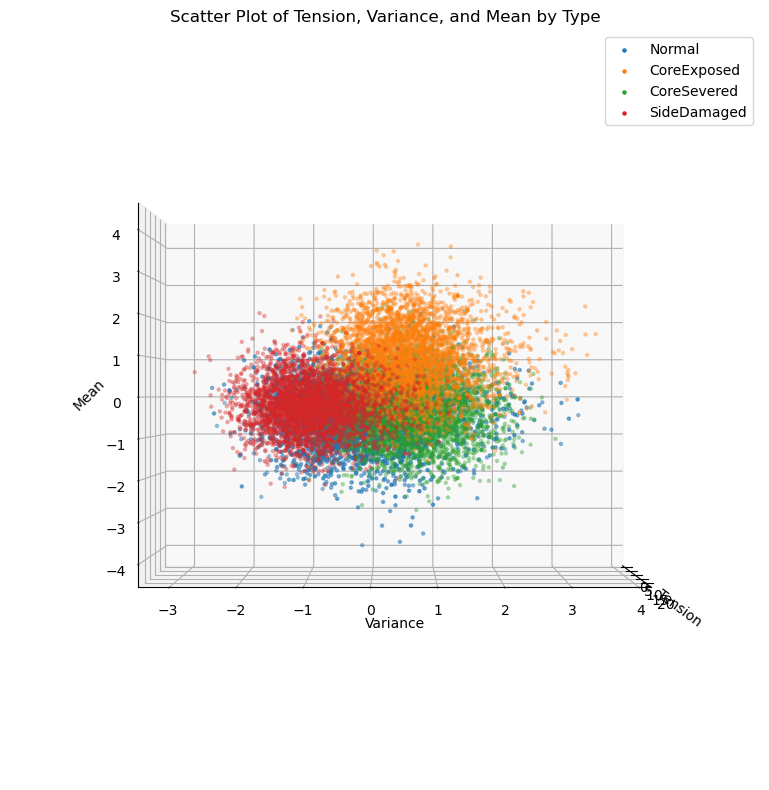

In [5]:
# 3차원 plot
# 독립 변수와 타겟 변수를 선택
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Type']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

tension = tb_data['Tension']
variance = tb_data['Variance']
mean = tb_data['Mean']
type = tb_data['Type']

for t in tb_data['Type'].unique().tolist():
    mask = type == t
    ax.scatter(tension[mask], variance[mask], mean[mask], label = t, marker = '.')

ax.set_xlabel('Tension', rotation=45)
ax.set_ylabel('Variance', rotation=45)
ax.set_zlabel('Mean', rotation=45)

azimuth_angle = 0
elevation_angle = 0
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Tension, Variance, and Mean by Type')
plt.tight_layout()
plt.show()

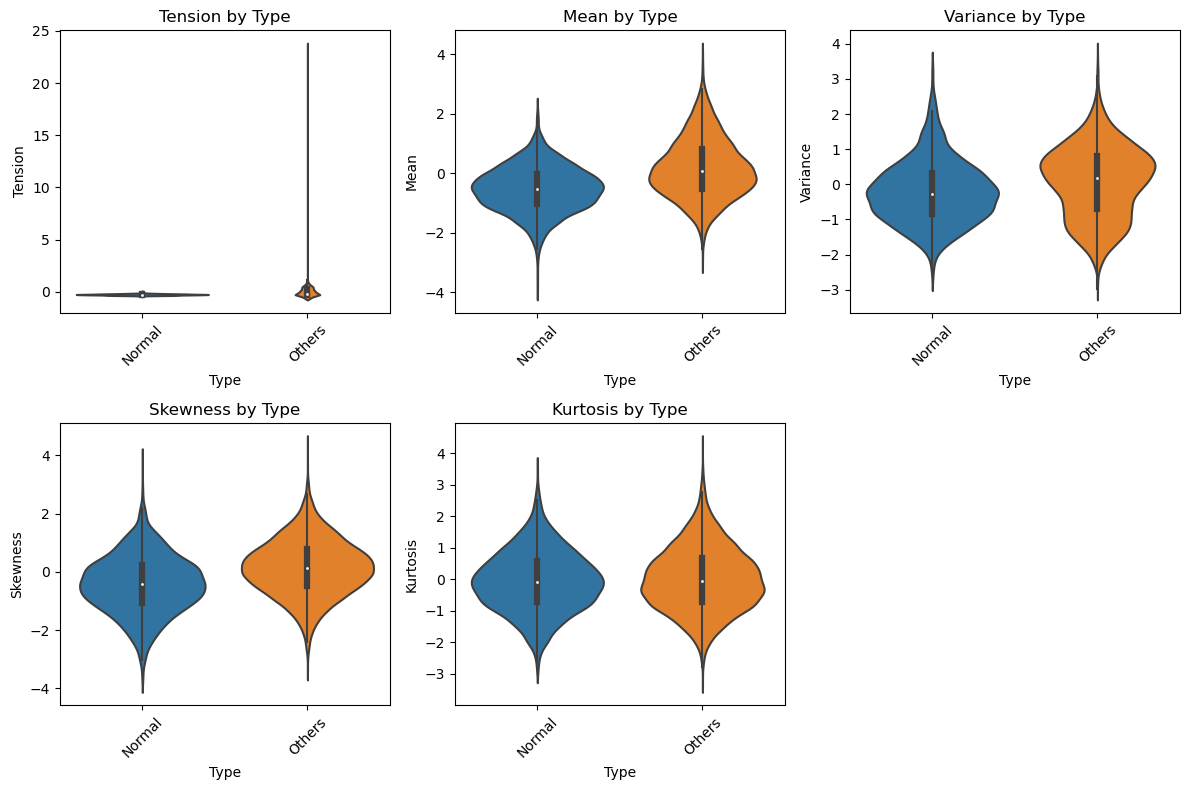

In [6]:
# 극단 이상치 제거하지 않은 바이올린 플롯
plt.figure(figsize=(12, 8))  # 그림 크기 설정

# 각 열에 대해 이상치 제거한 박스 플롯 그리기
for i, col in enumerate(list_independent_variables, 1):
    plt.subplot(2, 3, i)  # 2x3 그리드에서 i번째 위치에 서브플롯 생성

    sns.violinplot(x='Confusion Matrix', y=col, data=tb_data)
    plt.title(f'{col} by Type')  # 서브플롯 제목 설정
    plt.xlabel('Type')  # x축 레이블 설정
    plt.ylabel(col)  # y축 레이블 설정
    plt.xticks(rotation=45)  # x축 레이블 회전

plt.tight_layout()  # 레이아웃 조정
plt.show()

##### Normal를 분산이 가장 큰 축들에 사영하여 시각화했다. 동글동글한가?

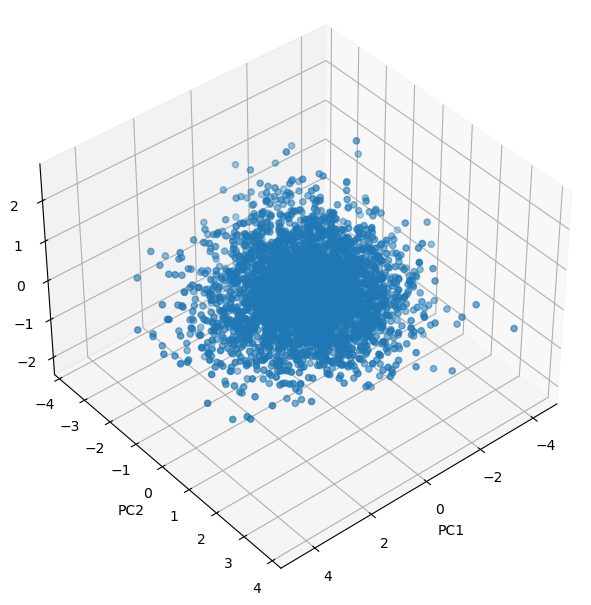

In [7]:
# Normal 데이터의 PCA 3차원 시각화
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')

pca = PCA(n_components = 3)
pca_normal = pca.fit_transform(tb_data.loc[tb_data['Type'] == 'Normal', list_independent_variables])
list_pca_normal_cols = [f'PC{i+1}' for i in range(pca_normal.shape[1])]
pca_normal = pd.DataFrame(data = pca_normal, columns = list_pca_normal_cols)

pc1 = pca_normal['PC1']
pc2 = pca_normal['PC2']
pc3 = pca_normal['PC3']

ax.scatter(pc1, pc2, pc3, marker = 'o')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

azimuth_angle = 50
elevation_angle = 40
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

# plt.title('PCA Scatter Plot of Normal')
plt.tight_layout()
plt.show()

##### Normal에 대해 집단과 데이터 포인트 사이의 Mahalanobis 거리 계산
##### 신뢰수준(n%)을 정하고 여러 개의 n분위수를 Bootstrap으로 구한 뒤 그 평균을 관리한계로 설정
##### False Alarm 발생

##### numpy로 거리 계산이 안 됨. T²가 e-13으로 계산되고, 거리 계산 위해 루트 씌우면 NaN 나옴.
##### 왜일까. 암튼 그래서 scipy.spatial.distance.mahalanobis 썼다.

In [8]:
# 14255개 데이터의 마할라노비스 거리 계산
warnings.filterwarnings('ignore') # 모든 경고 메시지 무시

type_normal = tb_data[tb_data['Type'] == 'Normal']
type_not_normal = tb_data[tb_data['Type'] != 'Normal']

normal_mean = type_normal[list_independent_variables].mean()
normal_cov = type_normal[list_independent_variables].cov()

def mahalanobis_distance(x):
    return distance.mahalanobis(x, normal_mean, normal_cov)

type_normal['Mahalanobis Distance'] = type_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)
type_not_normal['Mahalanobis Distance'] = type_not_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)

# bootstrap_iterations = 500
# confidence_level = 95

# list_bootstrap_statistics = []

# for _ in range(bootstrap_iterations):
#     bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size = len(type_normal), replace = True)
#     list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

# control_limit = np.mean(list_bootstrap_statistics)
# print(f'confidence level: {confidence_level}%')
# print(f'control limit: {control_limit}')

# type_normal.loc[type_normal['Mahalanobis Distance'] >= control_limit, 'Confusion Matrix'] = 'FalseAlarm' # 'Normal' = TrueNegative
# type_not_normal.loc[type_not_normal['Mahalanobis Distance'] >= control_limit, 'Confusion Matrix'] = 'TrueAlarm'
# type_not_normal.loc[type_not_normal['Mahalanobis Distance'] < control_limit, 'Confusion Matrix'] = 'Type2Error' # 'Anomaly' = TruePositive

# tb_data = pd.concat([type_normal, type_not_normal], axis = 0)

# tb_data

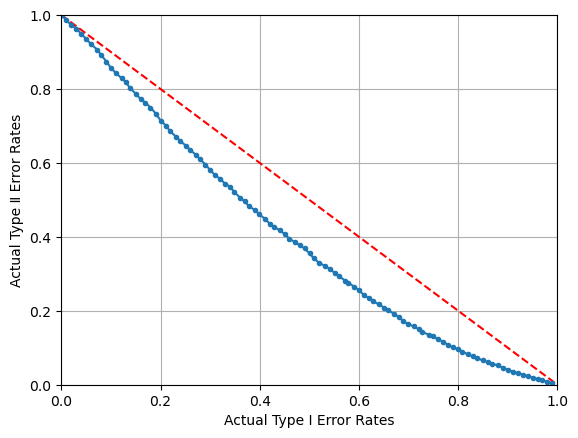

In [42]:

bootstrap_iterations = 100
list_ER = []

for confidence_level in range(1, 101):
    list_bootstrap_statistics = [] # 반복 횟수(100)만큼의 통계량을 저장할 빈 리스트
    
    for _ in range(bootstrap_iterations):
        bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size = len(type_normal), replace = True) # Normal 데이터(3581)개와 같은 양의 표본을 복원추출
        list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level)) # 확보한 3581개 표본에서 n(=confidence_level)분위수 한 개 추출. list_bootstrap_statistics에 추가
    # 위 반복문을 반복 횟수만큼 실행한 결과, list_bootstrap_statistics에 100개의 통계량이 저장됨. 이들은 모두 같은 신뢰구간에서 추출된 통계량임.
    control_limit = np.mean(list_bootstrap_statistics) # 100개 통계량의 평균

    type_normal['Confusion Matrix'] = np.where(type_normal['Mahalanobis Distance'] >= control_limit, 'FalseAlarm', 'TrueNegative')
    type_not_normal['Confusion Matrix'] = np.where(type_not_normal['Mahalanobis Distance'] >= control_limit, 'TrueAlarm', 'Type2Error')

    ftb_data = pd.concat([type_normal, type_not_normal], axis = 0) # 관리한계 안 넘은 정상들은 애초에 Normal로 레이블링 되어 있었다.
    
    Type1ErrorRates = round(len(ftb_data[ftb_data['Confusion Matrix'] == 'FalseAlarm'])/len(tb_data[tb_data['Type'] == 'Normal']), 4) # 제1종 오류 비율
    Type2ErrorRates = round(len(ftb_data[ftb_data['Confusion Matrix'] == 'Type2Error'])/len(tb_data[tb_data['Type'] != 'Normal']), 4) # 제2종 오류 비율
    
    list_ER.append([Type1ErrorRates, Type2ErrorRates])
    
x = [item[0] for item in list_ER]
y = [item[1] for item in list_ER]

plt.plot([0, 1], [1, 0], linestyle='--', color='red')#, label='y = -x')
plt.plot(x, y, marker='.', linestyle='-')

plt.xlabel("Actual Type Ⅰ Error Rates")
plt.ylabel("Actual Type Ⅱ Error Rates")

plt.grid(True)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

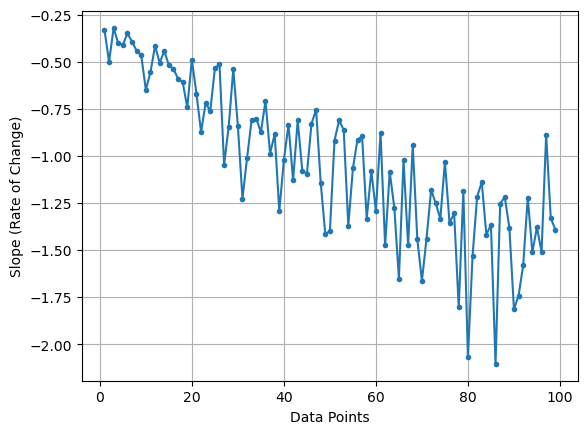

In [41]:
list_slope = []

for i in range(1, len(x)):
    delta_x = x[i] - x[i - 1]
    delta_y = y[i] - y[i - 1]
    rate = delta_y / delta_x
    list_slope.append(rate)

plt.plot(range(1, len(x)), list_slope, marker='.', linestyle='-')
plt.xlabel('Data Points')
plt.ylabel('Slope (Rate of Change)')
# plt.title('Slope Visualization')
plt.grid(True)
plt.show()

In [44]:
list_slope[31]

-1.0097087378640712

In [51]:
list_ER[31]

[0.6811, 0.1822]

In [113]:
warnings.filterwarnings('ignore') # 모든 경고 메시지 무시

# type_normal = tb_data[tb_data['Type'] == 'Normal']
# type_not_normal = tb_data[tb_data['Type'] != 'Normal']

normal_mean = type_normal[list_independent_variables].mean()
normal_cov = type_normal[list_independent_variables].cov()

def mahalanobis_distance(x):
    return distance.mahalanobis(x, normal_mean, normal_cov)

# type_normal['Mahalanobis Distance'] = type_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)
# type_not_normal['Mahalanobis Distance'] = type_not_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)

type_normal = tb_data[tb_data['Type'] == 'Normal']
type_not_normal = tb_data[tb_data['Type'] != 'Normal']

type_normal['Mahalanobis Distance'] = type_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)
type_not_normal['Mahalanobis Distance'] = type_not_normal[list_independent_variables].apply(mahalanobis_distance, axis = 1)

bootstrap_iterations = 500
confidence_level = 70

list_bootstrap_statistics = []

for _ in range(bootstrap_iterations):
    bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size = len(type_normal), replace = True)
    list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

control_limit = np.mean(list_bootstrap_statistics)
print(f'confidence level: {confidence_level}%')
print(f'control limit: {control_limit}')

type_normal.loc[type_normal['Mahalanobis Distance'] >= control_limit, 'Confusion Matrix'] = 'FalseAlarm' # 'Normal' = TrueNegative
type_not_normal.loc[type_not_normal['Mahalanobis Distance'] >= control_limit, 'Confusion Matrix'] = 'TrueAlarm'
type_not_normal.loc[type_not_normal['Mahalanobis Distance'] < control_limit, 'Confusion Matrix'] = 'Type2Error' # 'Anomaly' = TruePositive

ftb_data = pd.concat([type_normal, type_not_normal], axis = 0)

ftb_data

confidence level: 70%
control limit: 2.1622092527721253


,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:35:19,-0.216452,-1.780290,0.235485,-0.209677,0.005047,Normal,Normal,1.109174
1,2023-05-31 23:35:20,-0.204667,-0.470556,0.059753,0.655876,-0.858885,Normal,Normal,1.373444
2,2023-05-31 23:35:21,-0.216452,-1.040747,0.163329,0.333842,-0.392346,Normal,Normal,1.126269
3,2023-05-31 23:35:22,-0.240023,-1.600883,0.503912,-0.609384,-0.731790,Normal,Normal,1.522023
4,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,FalseAlarm,2.703300
...,...,...,...,...,...,...,...,...,...
14250,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,TrueAlarm,2.539571
14251,2023-05-31 21:53:56,-0.240023,-0.831468,-0.717530,0.131856,0.607366,SideDamaged,Type2Error,1.295017
14252,2023-05-31 21:53:57,0.007473,-0.539040,0.135900,0.228446,-0.148179,SideDamaged,Type2Error,0.712283
14253,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,TrueAlarm,2.965364


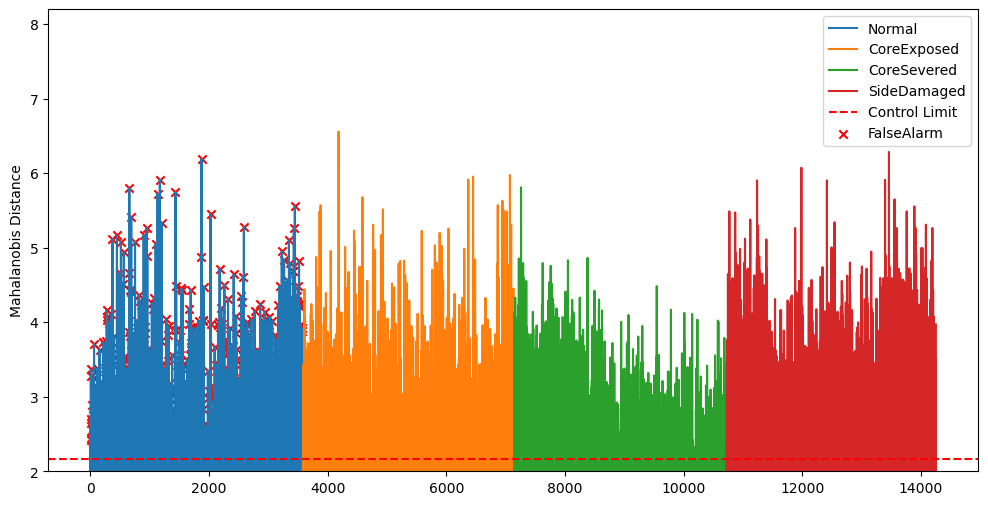

In [114]:
mahalanobis_distance = ftb_data['Mahalanobis Distance']

false_alarm_indices = ftb_data[ftb_data['Confusion Matrix'] == 'FalseAlarm'].index

plt.figure(figsize=(12, 6))

for t in tb_data['Type'].unique():
    type_indices = tb_data[tb_data['Type'] == t].index
    plt.plot(type_indices, mahalanobis_distance[type_indices], label=f'{t}') # 각 'Type'에 대한 Mahalanobis 거리 플롯
    
plt.axhline(y=control_limit, color='red', linestyle='--', label='Control Limit') # Control Limit 그리기

plt.scatter(false_alarm_indices, mahalanobis_distance[false_alarm_indices], c='red', marker='x', label='FalseAlarm') # 'Confusion Matrix' 값이 'Type1Error'인 데이터 포인트 표시

plt.ylabel('Mahalanobis Distance')
# plt.title('Mahalanobis Distance Monitoring Chart with Type Ⅰ Error')
plt.legend()

plt.ylim(2, 8.2) # y축 범위 설정

plt.show()

변수 중요도
Tension     0.120450
Mean        0.050333
Skewness    0.028058
Variance    0.021103
Kurtosis    0.001922
dtype: float64


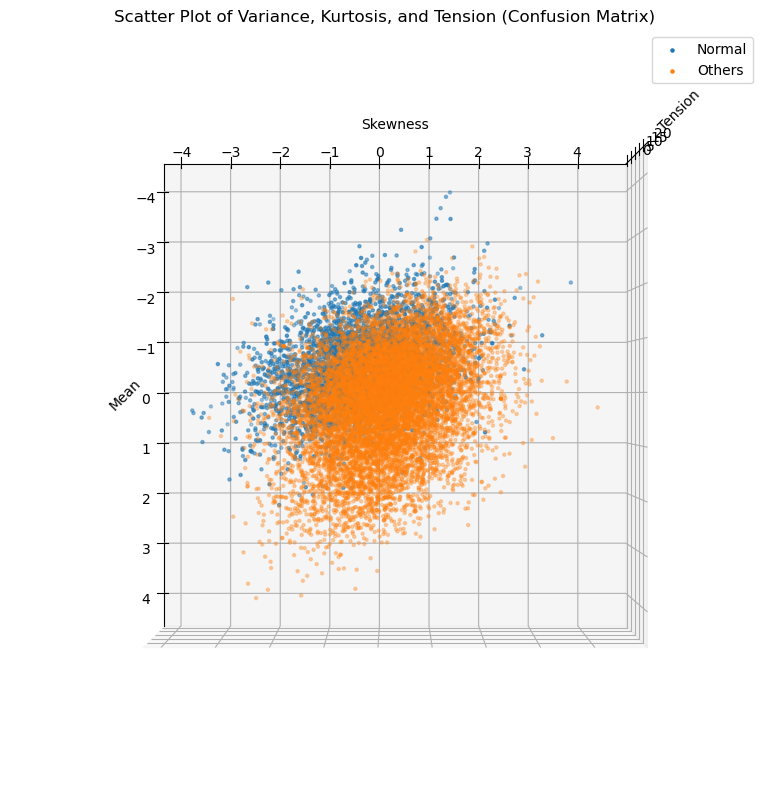

In [87]:
X = tb_data[list_independent_variables]  # 독립 변수
y = tb_data['Confusion Matrix']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111, projection='3d')
variance = tb_data['Variance']
kurtosis = tb_data['Kurtosis']
tension = tb_data['Tension']
mean = tb_data['Mean']
skewness = tb_data['Skewness']
confusion_matrix = tb_data['Confusion Matrix']

for t in tb_data['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(mean[mask], skewness[mask], tension[mask], label = t, marker = '.')

ax.set_xlabel('Mean', rotation=45)
ax.set_ylabel('Skewness', rotation=45)
ax.set_zlabel('Tension', rotation=45)

azimuth_angle = 0
elevation_angle = 90
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Variance, Kurtosis, and Tension (Confusion Matrix)')
plt.tight_layout()
plt.show()

##### 관리한계를 넘은 관측치(Out-of-control)는 False Alarm과 True Alarm으로 이루어짐

In [115]:
ooc = ftb_data[(ftb_data['Confusion Matrix'] == 'FalseAlarm') | (ftb_data['Confusion Matrix'] == 'TrueAlarm')]
ooc = ooc.reset_index(drop = True) # False는 기존 인덱스를 새로운 열로 추가
ooc

,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,FalseAlarm,2.703300
1,2023-05-31 23:35:26,-0.204667,-1.034286,1.395421,-0.806608,-1.992672,Normal,FalseAlarm,3.273487
2,2023-05-31 23:35:27,-0.310736,-1.042713,1.111624,-0.634537,-1.602608,Normal,FalseAlarm,2.644904
3,2023-05-31 23:35:33,-0.204667,-0.097436,1.904087,-0.537864,-1.713464,Normal,FalseAlarm,3.367810
4,2023-05-31 23:35:35,-0.216452,-1.453967,0.519922,-2.438339,-0.769439,Normal,FalseAlarm,2.418311
...,...,...,...,...,...,...,...,...,...
5561,2023-05-31 21:53:50,-0.216452,0.455385,-1.531015,-0.374059,2.338042,SideDamaged,TrueAlarm,3.503636
5562,2023-05-31 21:53:54,-0.228238,-1.672916,-0.913209,1.162352,1.635139,SideDamaged,TrueAlarm,3.090949
5563,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,TrueAlarm,2.539571
5564,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,TrueAlarm,2.965364


변수 중요도
Tension     0.108098
Skewness    0.031919
Mean        0.029664
Variance    0.009124
Kurtosis    0.000000
dtype: float64


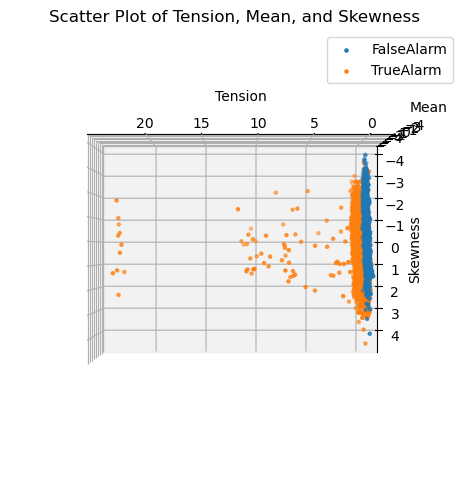

In [89]:
X = ooc[list_independent_variables]  # 독립 변수
y = ooc['Confusion Matrix']  # 타겟 변수

# 상호의존정보
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111, projection='3d')
tension = ooc['Tension']
mean = ooc['Mean']
skewness = ooc['Skewness']
confusion_matrix = ooc['Confusion Matrix']

for t in ooc['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(tension[mask], mean[mask], skewness[mask], label = t, marker = '.')

ax.set_xlabel('Tension')
ax.set_ylabel('Mean')
ax.set_zlabel('Skewness')

azimuth_angle = 90
elevation_angle = 180
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Tension, Mean, and Skewness')
plt.tight_layout()
plt.show()

##### 하하하하하하하하하하하하하하하하하하하하하
##### IQR을 이용하여 False Alarm의 Extreme Outliers를 정의할 수 있는 Outer Fence를 만듭시다.(Q3 + IQR * 3)

Upper Outer Fence: 0.019258668380449484


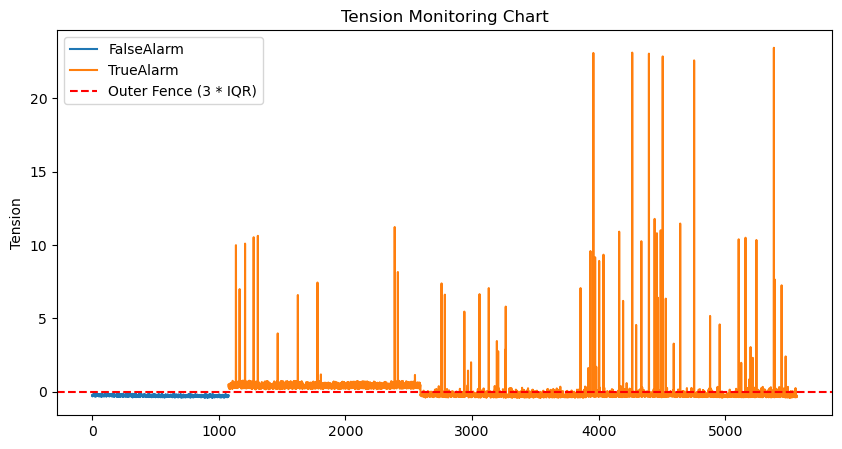

,index,Unnamed: 0,Tension,Mean,Variance,Skewness,Kurtosis,Type,Confusion Matrix,Mahalanobis Distance
0,0,2023-05-31 23:35:23,-0.240023,-0.172642,1.351871,0.541339,-1.517878,Normal,FalseAlarm,2.703300
1,1,2023-05-31 23:35:26,-0.204667,-1.034286,1.395421,-0.806608,-1.992672,Normal,FalseAlarm,3.273487
2,2,2023-05-31 23:35:27,-0.310736,-1.042713,1.111624,-0.634537,-1.602608,Normal,FalseAlarm,2.644904
3,3,2023-05-31 23:35:33,-0.204667,-0.097436,1.904087,-0.537864,-1.713464,Normal,FalseAlarm,3.367810
4,4,2023-05-31 23:35:35,-0.216452,-1.453967,0.519922,-2.438339,-0.769439,Normal,FalseAlarm,2.418311
...,...,...,...,...,...,...,...,...,...,...
3779,5561,2023-05-31 21:53:50,-0.216452,0.455385,-1.531015,-0.374059,2.338042,SideDamaged,TrueAlarm,3.503636
3780,5562,2023-05-31 21:53:54,-0.228238,-1.672916,-0.913209,1.162352,1.635139,SideDamaged,TrueAlarm,3.090949
3781,5563,2023-05-31 21:53:55,-0.298951,-1.252192,-1.108551,-2.155222,1.508766,SideDamaged,TrueAlarm,2.539571
3782,5564,2023-05-31 21:53:58,-0.263594,0.162395,-1.534583,0.175456,1.726651,SideDamaged,TrueAlarm,2.965364


In [116]:

FA = ftb_data[(ftb_data['Confusion Matrix'] == 'FalseAlarm')]
FA = FA.reset_index(drop = True) # False는 기존 인덱스를 새로운 열로 추가

Q1 = FA['Tension'].quantile(0.25)
Q3 = FA['Tension'].quantile(0.75)
IQR = Q3 - Q1
outer_fence = Q3 + 3 * IQR
print(f'Upper Outer Fence: {outer_fence}')

tension = ooc['Tension']

plt.figure(figsize=(10, 5))

for t in ooc['Confusion Matrix'].unique():
    type_indices = ooc[ooc['Confusion Matrix'] == t].index
    plt.plot(type_indices, tension[type_indices], label=f'{t}') # 각 'Type'에 대한 Mahalanobis 거리 플롯
    
plt.axhline(y=outer_fence, color='red', linestyle='--', label='Outer Fence (3 * IQR)') # Control Limit 그래프 그리기

plt.ylabel('Tension')
plt.title('Tension Monitoring Chart')
plt.legend()
plt.show()

fac_target = ooc[(ooc['Tension'] < outer_fence)]
extreme_outliers = ooc[(ooc['Tension'] >= outer_fence)]
fac_target = fac_target.reset_index(drop = False)
fac_target # Control Limit은 넘었지만 Outer Fence는 안 넘음
# extreme_outliers # FAC 필요 없이 아묻따 Anomaly. 바로 Type 분류하면 됨

변수 중요도
Skewness    0.048750
Tension     0.027367
Variance    0.015221
Kurtosis    0.002987
Mean        0.000000
dtype: float64


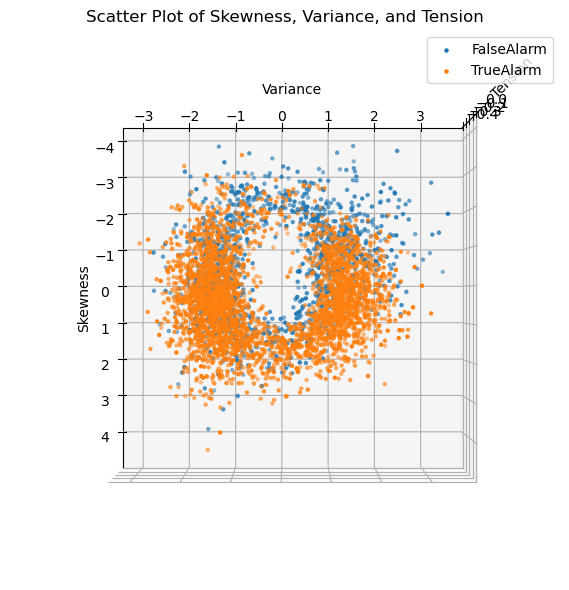

In [91]:
# 독립 변수와 타겟 변수를 선택
X = fac_target[list_independent_variables]  # 독립 변수
y = fac_target['Confusion Matrix']  # 타겟 변수

# 상호 정보량 계산
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# 결과 출력
importance_scores = pd.Series(mutual_info, index=X.columns)
importance_scores = importance_scores.sort_values(ascending=False)
print('변수 중요도')
print(importance_scores)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

skewness = fac_target['Skewness']
variance = fac_target['Variance']
tension = fac_target['Tension']
confusion_matrix = fac_target['Confusion Matrix']

for t in fac_target['Confusion Matrix'].unique().tolist():
    mask = confusion_matrix == t
    ax.scatter(skewness[mask], variance[mask], tension[mask], label = t, marker = '.')

ax.set_xlabel('Skewness', rotation=45)
ax.set_ylabel('Variance', rotation=45)
ax.set_zlabel('Tension', rotation=45)

azimuth_angle = 0
elevation_angle = 90
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()
plt.title('Scatter Plot of Skewness, Variance, and Tension')
plt.tight_layout()
plt.show()

##### 간단하게 LDA로 분류해보자

Classification Report:
               precision    recall  f1-score   support

   TrueAlarm       0.71      0.71      0.71         7
  FalseAlarm       0.88      0.88      0.88        17

    accuracy                           0.83        24
   macro avg       0.80      0.80      0.80        24
weighted avg       0.83      0.83      0.83        24



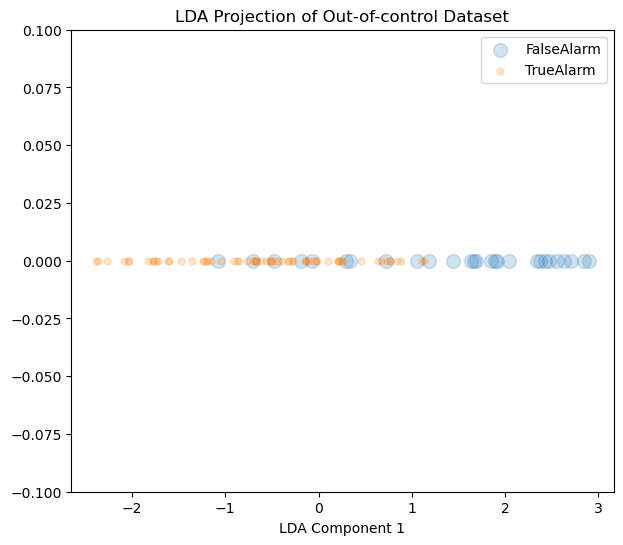

In [117]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) # 비율 유지

# LDA 모델 생성 및 학습
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

# 테스트 데이터를 LDA에 적용
X_test_lda = lda.transform(X_test)

# 분류 모델 (예: 로지스틱 회귀)을 통해 훈련 및 평가
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)
y_pred = classifier.predict(X_test_lda)

report = classification_report(y_test, y_pred, target_names=y_train.unique())
print("Classification Report:\n", report)

plt.figure(figsize=(7, 6))
for label in y.unique():
    if label == 'TrueAlarm':
        marker = '.'
    elif label == 'FalseAlarm':
        marker = 'o'
    plt.scatter(X_train_lda[y_train == label], [0] * sum(y_train == label), label=label, alpha=0.2, marker=marker, s=100) # 선명도alpha

plt.xlabel('LDA Component 1')
plt.ylim(-0.1, 0.1)  # 1차원 공간에 표시
plt.legend(loc='best') #최적 위치로
plt.title('LDA Projection of Out-of-control Dataset')
plt.show()

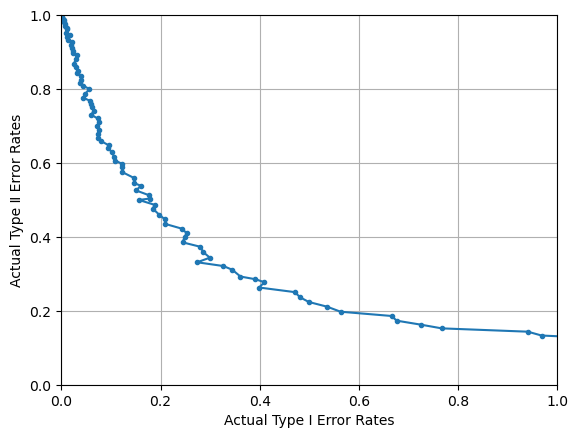

In [118]:
x_values = [item[1] for item in list_ActualErrorRates]
y_values = [item[2] for item in list_ActualErrorRates]

plt.plot(x_values, y_values, marker='.', linestyle='-')

plt.xlabel("Actual Type Ⅰ Error Rates")
plt.ylabel("Actual Type Ⅱ Error Rates")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.grid(True)

# Show the plot
plt.show()

In [102]:
list_ActualErrorRates = []
bootstrap_iterations = 100 # Bootstraping 반복 횟수

type_normal = tb_data[tb_data['Type'] == 'Normal']
type_not_normal = tb_data[tb_data['Type'] != 'Normal']

type_normal['Mahalanobis Distance'] = type_normal[list_independent_variables].apply(mahalanobis_distance, axis=1) # 'Normal'('Type') 데이터의 Mahalanobis 거리
type_not_normal['Mahalanobis Distance'] = type_not_normal[list_independent_variables].apply(mahalanobis_distance, axis=1) # 'Normal'이 아닌 데이터의 거리

normal_mean = type_normal[list_independent_variables].mean()
normal_cov = type_normal[list_independent_variables].cov()

def mahalanobis_distance(x): # Mahalanobis 거리 계산을 위한 함수
    return distance.mahalanobis(x, normal_mean, normal_cov)

for confidence_level in range(1, 100):
    list_bootstrap_statistics = [] # 원하는 통계량을 저장할 빈 리스트

    for _ in range(bootstrap_iterations): # 3581개 복원추출(1회)을 100회 반복. 매회 신뢰구간에 따른 임계점을 빈 리스트에 저장
        bootstrap_sample = np.random.choice(type_normal['Mahalanobis Distance'], size=len(type_normal), replace=True) # 'Normal'에 대해 원본 데이터프레임 행 갯수만큼 복원추출
        list_bootstrap_statistics.append(np.percentile(bootstrap_sample, confidence_level))

    control_limit = np.mean(list_bootstrap_statistics) # 100개 임계점의 평균. 관리한계

    type_normal['Confusion Matrix'] = np.where(type_normal['Mahalanobis Distance'] >= control_limit, 'FalseAlarm', 'TrueNegative')
    type_not_normal['Confusion Matrix'] = np.where(type_not_normal['Mahalanobis Distance'] >= control_limit, 'TrueAlarm', 'Type2Error')

    new_tb_data = pd.concat([type_normal, type_not_normal], axis=0)

    ooc = new_tb_data[(new_tb_data['Confusion Matrix'] == 'FalseAlarm') | (new_tb_data['Confusion Matrix'] == 'TrueAlarm')]

    FA = new_tb_data[(new_tb_data['Confusion Matrix'] == 'FalseAlarm')]
    
    Q1 = FA['Tension'].quantile(0.25)
    Q3 = FA['Tension'].quantile(0.75)
    IQR = Q3 - Q1
    outer_fence = Q3 + 3 * IQR

    fac_target = ooc[(ooc['Tension'] < outer_fence)]
    extreme_outliers = ooc[(ooc['Tension'] >= outer_fence)]

    X = fac_target[list_independent_variables]  # 독립변수
    y = fac_target['Confusion Matrix']  # 종속변수

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 비율 유지

    n_train_normal = len(fac_target[fac_target.loc[fac_target['Confusion Matrix'].isin(y_train), 'Type'] == 'Normal'])
    n_train_others = len(fac_target[fac_target.loc[fac_target['Confusion Matrix'].isin(y_train), 'Type'] != 'Normal'])

    # LDA 모델 생성 및 학습
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train, y_train)

    X_test_lda = lda.transform(X_test) # 테스트 데이터를 LDA에 적용

    classifier = LogisticRegression() # LogisticRegression으로 구성된 분류기
    classifier.fit(X_train_lda, y_train)
    y_pred = classifier.predict(X_test_lda)

    n_normal = len(tb_data[tb_data['Type'] == 'Normal']) # 'Normal' 데이터 개수
    n_fault = len(tb_data[tb_data['Type'] != 'Normal']) # 'Normal'이 아닌 데이터 개수
    n_alpha = len(y_pred[y_pred == 'FalseAlarm']) # 제1종오류 개수
    n_beta = len(new_tb_data[new_tb_data['Confusion Matrix'] == 'Type2Error']) # 제2종오류 개수

    ActualType1ErrorRates = round(n_alpha/(n_normal-n_train_normal), 4)
    ActualType2ErrorRates = round(n_beta/(n_fault-n_train_others), 4)

    list_ActualErrorRates.append([(100 - confidence_level)/100, ActualType1ErrorRates, ActualType2ErrorRates])

In [ ]:
n_alpha/(n_normal-n_train_normal)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fac_target[list_independent_variables], fac_target['Confusion Matrix'], test_size=0.2, random_state=42, stratify=y)

n_train_normal = len(fac_target[fac_target.loc[fac_target['Confusion Matrix'].isin(y_train), 'Type'] == 'Normal'])
n_train_others = len(fac_target[fac_target.loc[fac_target['Confusion Matrix'].isin(y_train), 'Type'] != 'Normal'])

In [ ]:
for i in range(0, 3):
    print(i)

In [ ]:
tb_data

##### 이제 유의수준에 따른 두 가지 Type Error Rates 비교해야돼

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report # 왜 가끔 말을 안 듣지

list_dependent_variables = ['Type', 'Confusion Matrix']

# PCA
pca = PCA(n_components = 3)
pca_fa = pca.fit_transform(fac_target.loc[fac_target['Confusion Matrix'] == 'FalseAlarm', list_independent_variables])
list_pca_fa_cols = [f'PC{i+1}' for i in range(pca_fa.shape[1])]
pca_fa = pd.concat([pd.DataFrame(data = pca_fa, columns = list_pca_fa_cols), fac_target.loc[fac_target['Confusion Matrix'] == 'FalseAlarm', list_dependent_variables]], axis = 1)

pca_ta = pca.transform(fac_target.loc[fac_target['Confusion Matrix'] != 'FalseAlarm', list_independent_variables])
list_pca_ta_cols = [f'PC{i+1}' for i in range(pca_ta.shape[1])]
pca_ta = pd.concat([pd.DataFrame(data = pca_ta, columns = list_pca_ta_cols), fac_target.loc[fac_target['Confusion Matrix'] != 'FalseAlarm', list_dependent_variables].reset_index(drop = True)], axis = 1)

pca_fata = pd.concat([pca_fa, pca_ta], axis = 0)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection = '3d')

pc1 = pca_fata['PC1']
pc2 = pca_fata['PC2']
pc3 = pca_fata['PC3']
type = pca_fata['Confusion Matrix']

for t in pca_fata['Confusion Matrix'].unique().tolist():
    mask = type == t
    ax.scatter(pc1[mask], pc2[mask], pc3[mask], label = t, marker = '.')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

azimuth_angle = 0
elevation_angle = 90
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

plt.legend()
plt.title('PCA Scatter Plot')
plt.tight_layout()
plt.show()

X = pca_fata[list_pca_ta_cols]
y = pca_fata['Confusion Matrix']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42, max_depth=7)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

# Type Ⅰ Error와 Type Ⅱ Error의 비율을 시각화하여 모델을 선택하자.

# class_labels = ['Others', 'FalseAlarm']

# cm_rf = confusion_matrix(y_test, y_pred_rf)

# plt.figure(figsize=(4, 3))

# sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('PCA & RF Confusion Matrix')

# plt.tight_layout()
# plt.show()

# print("PCA & Random Forest Classification Report:")
# print(classification_report(y_test, y_pred_rf, target_names=class_labels))